# Book Success Prediction using Machine Learning

Kathryn Hamilton and Frank Shannon

w207 Spring 2018

### Introduction

The team would like to assess the relationship between the synopsis of a novel and its success by constructing a supervised machine learning classifier.

A book's synopsis, which is a couple paragraphs traditionally found on the back or inside cover of a book, serves to provide a brief explanation of the book's contents and any applicable critical acclaim of the the author. The team would like to see if this information can be used to reliably predict whether or not the book will be successful. To do this, the team will study harness information found on Amazon.com, one of the world's largest e-commerce and cloud computing companies which, fittingly, started as an online bookstore.

We begin by importing the necessary libraries and setting up our document.

In [37]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import pandas as pd
import gzip
import re
import copy

np.random.seed(0)

import warnings
warnings.filterwarnings('ignore')

The data we will be using for this project come from two sources.

The first is an online repository of `.json` files compiled by Julian McAuley, Assistant Professor of Computer Science and Engineering at University of California, San Diego. These files, which can be found at http://jmcauley.ucsd.edu/data/amazon/ and will provides us with customer review information and product metadata [1, 2].

The second will be an API the team uses to scrape book synopsis data from http://www.amazon.com/ using the list of product ID numbers included in the dataset of reviews.

Prof. McAuley's papers related to the Amazon dataset are as follows:

[1] R. He, J. McAuley. Modeling the visual evolution of fashion trends with one-class collaborative filtering. WWW, 2016

[2] J. McAuley, C. Targett, J. Shi, A. van den Hengel. Image-based recommendations on styles and substitutes. SIGIR, 2015

### Import and Clean Metadata

We first explore the datasets provided by McAuley. These files are very large so we are looking to get rid of any information that will not be useful to us.

In addition, we will want to narrow down the data into a subset that seems well suited for the purpose of this project. For starters, this means selecting a category of books (Fiction, Travel, Money & Business, etc) that has enough examples and a good range of descriptive synopses.

At this point in the project our inputs and outputs are very loosely defined. It is hard to know specifically what we data will need in the end and if we even have it to begin with. So, some upfront exploration is a good first approach to begin forming a problem that we can reasonably solve.

In [3]:
# Unpackage McAuley metadata and reviews files, which are currently compressed .json files, using the code supplied on his site.

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0 
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

Import medatadata file (or alternatively upload a saved file).

In [4]:
metadata_import = getDF('meta_Books.json.gz')

In [3]:
# Alternative
metadata = pd.read_pickle('metadata.pkl')

Let's take a look at the first few rows of the `metadata` file.

In [5]:
print "Length: ", len(metadata_import)   # print length of dataframe
metadata_import.head(n=5)   # print first 5 rows of dataframe

Length:  2370585


,asin,salesRank,imUrl,categories,title,description,related,price,brand
0,0001048791,{u'Books': 6334800},http://ecx.images-amazon.com/images/I/51MKP0T4...,[[Books]],"The Crucible: Performed by Stuart Pankin, Jero...",NaN,NaN,NaN,NaN
1,0001048775,{u'Books': 13243226},http://ecx.images-amazon.com/images/I/5166EBHD...,[[Books]],Measure for Measure: Complete &amp; Unabridged,William Shakespeare is widely regarded as the ...,NaN,NaN,NaN
2,0001048236,{u'Books': 8973864},http://ecx.images-amazon.com/images/I/51DH145C...,[[Books]],The Sherlock Holmes Audio Collection,"&#34;One thing is certain, Sherlockians, put a...","{u'also_viewed': [u'1442300191', u'9626349786'...",9.26,NaN
3,0000401048,{u'Books': 6448843},http://ecx.images-amazon.com/images/I/41bchvIf...,[[Books]],The rogue of publishers' row;: Confessions of ...,NaN,{u'also_viewed': [u'068240103X']},NaN,NaN
4,0001019880,{u'Books': 9589258},http://ecx.images-amazon.com/images/I/61LcHUdv...,[[Books]],Classic Soul Winner's New Testament Bible,NaN,"{u'also_viewed': [u'B003HMB5FC', u'0834004593'...",5.39,NaN


Let's start with the `metadata` file, which describes each book.

Immediately, we see that there are several columns that will likely be of use to us:

* `asin`, which is the unique product identification number used by Amazon.
* `salesRank`, which describes the popularity of the book within the Amazon category "Books".
* `categories`, which describes the category and sub category that the book is classified as.

There are also several columns that are not of use to us:

* `imUrl`, which is a link to the product's photo.
* `related`, which is a list of similar products.
* `brand`, which might describe affiliate companies such as the book's publisher

The first thing to do is process these fields to be the correct data type and organize the information to be suited to our project.

In [6]:
metadata = metadata_import.copy()   # create a duplicate data frame of the imported file

# convert column headers from unicode to ascii
metadata = metadata.rename(index=str,columns={u'asin':'asin', u'salesRank':'salesRank', u'imUrl':'imUrl', 
                                              u'categories':'categories', u'title':'title', u'description':'description',
                                              u'related':'related', u'price':'price', u'brand':'brand'})

metadata = metadata.drop(['imUrl','related','brand'],axis=1)   # drop unrelated columns

print "Length: ", len(metadata)   # print length of dataframe

Length:  2370585


Let's fix the syntax of the `salesRank` column so it displays as simple integer. We will set the rank to 0 for any entry that is NaN-valued, or has a ranking in a cartegory other than "Books".

In [7]:
metadata['salesRank'][metadata['salesRank'].isnull()] = 0
metadata['salesRank'] = metadata['salesRank'].astype(str)
metadata['salesRank'][~metadata['salesRank'].str.contains('Books')] = 0

metadata['salesRank'] = metadata['salesRank'].astype(str)
metadata['salesRank'] = metadata['salesRank'].str.lstrip("{'Books': ")   # strip json/unicode characters from left
metadata['salesRank'] = metadata['salesRank'].str.rstrip("}")   # strip json/unicode characters from right
metadata['salesRank'] = metadata['salesRank'].astype('int64')   # set column to be integer type

C:\Users\KHAMIL42\AppData\Local\Continuum\anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\KHAMIL42\AppData\Local\Continuum\anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Let's take a quick look at the distribution of `salesRank`. Remember that zero-valued rankings are equivalent to `NA`.

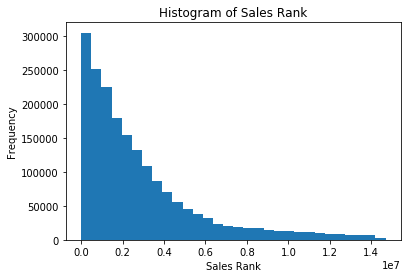

In [9]:
plt.hist(metadata['salesRank'][metadata['salesRank']!=0], bins=30)
plt.xlabel('Sales Rank')
plt.ylabel('Frequency')
plt.title('Histogram of Sales Rank')
plt.show()

While we're at it, let's also take a look at the distribution of `price`. We see that it is roughly normal with a heavy right-skew.

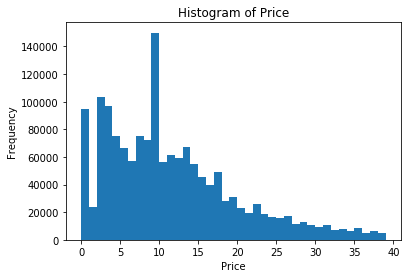

In [11]:
plt.hist(metadata['price'].dropna(axis=0), bins = range(0,40))
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Histogram of Price')
plt.show()

Note that this graph continues to the right quite a ways.

In [15]:
print "Maximum Price:", metadata['price'].max()
print "Minimum Price:", metadata['price'].min()
print "Mean Price:", round(metadata['price'].mean(),2)
print "Median Price:", metadata['price'].median()

Maximum Price: 999.99
Minimum Price: 0.0
Mean Price: 17.63
Median Price: 10.54


We have over two million titles to work with, which is great. Ideally we would like to narrow this down to a more workable size, likely by choosing a certain category or genre of books.

Let's check to see how many books fall into each category.

In [14]:
# convert to string and then group, sort and display
metadata['categories'] = metadata['categories'].astype(str)
metadata.drop(['salesRank','title','description','price'],axis=1).groupby(['categories']).count().sort_values('asin', ascending=False)

,asin
categories,
[['Books']],1940253
"[['Books', 'Literature & Fiction', 'Erotica'], ['Kindle Store', 'Kindle eBooks', 'Literature & Fiction', 'Erotica']]",8113
"[['Books', 'Literature & Fiction'], ['Books', 'Romance', 'Contemporary'], ['Kindle Store', 'Kindle eBooks', 'Romance', 'Contemporary']]",4060
"[['Books', 'Literature & Fiction', 'Erotica'], ['Kindle Store', 'Kindle eBooks', 'Literature & Fiction', 'Erotica', 'Romantic Erotica']]",3189
"[['Books', 'Literature & Fiction', 'Contemporary'], ['Kindle Store', 'Kindle eBooks', 'Literature & Fiction', 'Contemporary Fiction']]",3154
"[['Books', 'Literature & Fiction', 'Erotica'], ['Kindle Store', 'Kindle eBooks', 'Literature & Fiction', 'Erotica', 'BDSM']]",3096
"[['Books', 'Reference', 'Words, Language & Grammar', 'Linguistics'], ['Kindle Store', 'Kindle eBooks', 'Reference', 'Words, Language & Grammar', 'Linguistics']]",1692
"[['Books', 'Literature & Fiction'], ['Books', 'Romance'], ['Kindle Store', 'Kindle eBooks', 'Romance']]",1599
"[['Books', 'Literature & Fiction'], ['Books', 'Romance', 'Contemporary'], ['Kindle Store', 'Kindle eBooks', 'Literature & Fiction', 'Contemporary Fiction', 'Romance'], ['Kindle Store', 'Kindle eBooks', 'Romance', 'Contemporary']]",1550


The above a table of unique categories listed in descending number of books per category. We see that 1.9 million entries are uncategorized (their category is simply `Books`). However, this still leaves about 0.5 million books that have been categorized.

We see that there is an issue here with overcategorization. For example, we see that there are several of the above rows that fall under `Literature & Fiction` but have been specified further such that in their current format these entries are not bucketed together. 

The next logical step is to roll back these classifications to a higher level (for example, change `['Books', 'Literature & Fiction', 'Contemporary']` into simply `Literature & Fiction`), and then regroup the data.

In [16]:
metadata['categories'] = metadata['categories'].astype(str)
orig_categs = metadata.categories.values   # Get a list of all categories
orig_categs = np.unique(orig_categs)   # Cut this down to only the unique categories

new_categs = copy.copy(orig_categs)   # Create a copy of this list

for i in range(0,len(new_categs)):   # For each unique category
    text = re.sub('[^a-zA-Z&, ]+', '', str(new_categs[i]))   # Remove all the extra symbols and space
    text = text.split(",")   # Split by comma
    if len(text)>1:   # If there is more than one element (category contains a sub category)
        new_categs[i] = text[1].lstrip(' ')   # New category name is the first sub category
    else:   # If there is no sub category
        new_categs[i] = 'Books'   # New category name is simply "books"

print "New, simpler categories are: \n\n", np.unique(new_categs)   # print new categories

New, simpler categories are: 

['Arts & Photography' 'Biographies & Memoirs' 'Books' 'Business & Money'
 'Calendars' 'Childrens Books' 'Christian Books & Bibles'
 'Comics & Graphic Novels' 'Computers & Technology' 'Cookbooks' 'Crafts'
 'Crafts & Sewing' 'Diapering' 'Education & Teaching'
 'Engineering & Transportation' 'Exterior Accessories' 'Gay & Lesbian'
 'Health' 'Health & Baby Care' 'History' 'Humor & Entertainment' 'Law'
 'Literature & Fiction' 'Medical Books' 'Mystery' 'New'
 'Parenting & Relationships' 'Politics & Social Sciences' 'Reference'
 'Religion & Spirituality' 'Romance' 'Science & Math'
 'Science Fiction & Fantasy' 'SelfHelp' 'Sports & Outdoors'
 'Teen & Young Adult' 'Travel']


These categories look to be at a great level for our analysis!

Now have a way to map the original categories into the list above. Some examples of this mapping are seen below.

In [19]:
pd.DataFrame(np.column_stack((orig_categs, new_categs)), columns = ("OldLabel","NewLabel")).head(n=10)

,OldLabel,NewLabel
0,"[['Arts, Crafts & Sewing', 'Beading & Jewelry-...",Crafts & Sewing
1,"[['Arts, Crafts & Sewing', 'Beading & Jewelry-...",Crafts & Sewing
2,"[['Arts, Crafts & Sewing', 'Craft Supplies', '...",Crafts & Sewing
3,"[['Arts, Crafts & Sewing', 'Craft Supplies', '...",Crafts & Sewing
4,"[['Arts, Crafts & Sewing', 'Knitting & Crochet...",Crafts & Sewing
5,"[['Arts, Crafts & Sewing', 'Knitting & Crochet...",Crafts & Sewing
6,"[['Arts, Crafts & Sewing', 'Knitting & Crochet...",Crafts & Sewing
7,"[['Arts, Crafts & Sewing', 'Knitting & Crochet...",Crafts & Sewing
8,"[['Arts, Crafts & Sewing', 'Knitting & Crochet...",Crafts & Sewing
9,"[['Arts, Crafts & Sewing', 'Knitting & Crochet...",Crafts & Sewing


Let's replace the categories in the dataframe according to the mapping.

In [49]:
metadata['categories'] = metadata['categories'].astype(str)   # convert categories from objects to strings
#for i in range(0,len(orig_categs)):
for i in range(0, len(orig_categs)):
    metadata['categories'] = metadata['categories'].replace(str(orig_categs[i]), str(new_categs[i]))

We've done a lot of heavy computation so let's make sure we don't lose it.

In [46]:
metadata_backup = metadata.copy()
metadata.to_pickle('metadata.pkl')

Now let's take another look at how many examples we have in each category.

In [3]:
# convert to string and then group, sort and display
metadata['categories'] = metadata['categories'].astype(str)
metadata.drop(['salesRank','title','description','price'],axis=1).groupby(['categories']).count().sort_values('asin', ascending=False)

,asin
categories,
Books,1940253
Literature & Fiction,200791
Childrens Books,25424
Christian Books & Bibles,22470
Business & Money,18174
Biographies & Memoirs,18145
Health,18036
Cookbooks,11678
Gay & Lesbian,11533


Amazing! Now we have plenty of examples in each category.

Unfortunately, very few examples in these categories have information in the `salesRank` field. So we will not be able to reliably use the `salesRank` field.

In [4]:
metadata2 = metadata[metadata['salesRank'] != 0]
metadata2.drop(['salesRank','title','description','price'],axis=1).groupby(['categories']).count().sort_values('asin', ascending=False)

,asin
categories,
Books,1890996
Health,6
Sports & Outdoors,4
Crafts,2
Reference,2
Arts & Photography,1
Childrens Books,1
Computers & Technology,1
New,1


Under further investigation we found that this was because the `salesRank` field was either empty for examples that had been categorized further than `Books`, or showed a salesRank within a subcategory of `Books` that was far too specific to reasonably unravel in the timeline of this project. So we have chosen to go ahead without using `salesRank`.

Regardless, we are now at a good place to downsize the amount of data we are working with by selecting a few categories to continue with for this project.

We are looking for categories that will have meaningful keywords in the book's description that are common across the category in general. This means we want something based in fact rather than fiction.

We also want to pick categories with enough variance that books do not tend to duplicate content and thus descriptions still contain a slightly subjective element. For example, we might run into a problem in the Reference category wherein multiple calculus textbooks might exist with virtually the same descriptions and content. Politics & Social Sciences, on the other hand, might have enough common foundational ground while still being subject to opinions and other variances.

We have decided to move forward with the following categories:

* Business & Money
* History
* Computers & Technology
* Politics & Social Sciences

In [4]:
busi = metadata[metadata['categories'] == 'Business & Money']
hist = metadata[metadata['categories'] == 'History']
tech = metadata[metadata['categories'] == 'Computers & Technology']
poli = metadata[metadata['categories'] == 'Politics & Social Sciences']

bhtp_data = pd.concat([busi,hist,tech,poli])   # Create a dataframe with all of the relevant data, to use for scraping, etc.

Let's look at a few rows of the dataframe to get reacquainted with where we are.

In [5]:
bhtp_data.head(n=5)   # print first 5 rows of dataframe

,asin,salesRank,categories,title,description,price
962599,0976963094,0,Business & Money,Dave Ramsey's ACT Your Wage! Board Game,Get gazelle intense with this new board game f...,20.27
1769347,9810579357,0,Business & Money,The Art and Science of Entrepreneurship,"In the Art and Science of Entrepreneurship, In...",NaN
1775923,B0000547EU,0,Business & Money,NaN,Known as the father of contemporary negotiatin...,NaN
1775933,B00005MCQC,0,Business & Money,NaN,NaN,NaN
1775934,B00005MB6I,0,Business & Money,NaN,NaN,NaN


### Import and Clean Review Data

Now let's turn our attention to the other dataset provided by McAuley. This set contains over 22 million star rating tuples for the same books referenced in the `metadata` dataset. This set has already been cleaned and deduplicated.

In [6]:
reviews_import = pd.read_csv('ratings_Books.csv', names = ['user','asin','rating','timestamp'])

In [7]:
print "Length: ", len(reviews_import)   # print length of dataframe
reviews_import.head(n=5)   # print first 5 rows of dataframe

Length:  22507155


,user,asin,rating,timestamp
0,AH2L9G3DQHHAJ,0000000116,4.0,1019865600
1,A2IIIDRK3PRRZY,0000000116,1.0,1395619200
2,A1TADCM7YWPQ8M,0000000868,4.0,1031702400
3,AWGH7V0BDOJKB,0000013714,4.0,1383177600
4,A3UTQPQPM4TQO0,0000013714,5.0,1374883200


We only need `asin` and `rating` for the purpose of this project. Additionally, we can drop all of the rows that do not reference a book in one of the four categories that we have chosen.

In [9]:
reviews = reviews_import.drop(labels = ['user','timestamp'], axis = 'columns')
reviews = reviews[reviews['asin'].isin(bhtp_data['asin'])]
print "Length: ", len(reviews)   # print length of dataframe

Length:  180125


Let's compile the ratings into a list and insert them into the `metadata` dataframe, then take a look to see what we have done so far.

In [10]:
bhtp_data = bhtp_data.reset_index(drop=True)
bhtp_data['ratings'] = np.nan
bhtp_data['ratings'] = bhtp_data['ratings'].astype(object)
for i in range(0,len(bhtp_data)):
    rev_sub = reviews[reviews['asin'] == bhtp_data.iloc[i]['asin']]
    revs = np.asarray(rev_sub['rating'])
    bhtp_data.set_value(i,'ratings', revs)

In [13]:
bhtp_data.to_pickle('bhtp_data.pkl')
bhtp_data.head(n=10)

,asin,salesRank,categories,title,description,price,ratings
0,0976963094,0,Business & Money,Dave Ramsey's ACT Your Wage! Board Game,Get gazelle intense with this new board game f...,20.27,"[4.0, 4.0, 5.0, 2.0, 5.0, 4.0, 5.0, 5.0, 5.0, ..."
1,9810579357,0,Business & Money,The Art and Science of Entrepreneurship,"In the Art and Science of Entrepreneurship, In...",NaN,[5.0]
2,B0000547EU,0,Business & Money,NaN,Known as the father of contemporary negotiatin...,NaN,[5.0]
3,B00005MCQC,0,Business & Money,NaN,NaN,NaN,"[4.0, 4.0, 3.0]"
4,B00005MB6I,0,Business & Money,NaN,NaN,NaN,"[1.0, 5.0]"
5,B00005MB8F,0,Business & Money,NaN,NaN,NaN,"[1.0, 1.0]"
6,B00005MB9S,0,Business & Money,NaN,NaN,NaN,[1.0]
7,B00005MFBG,0,Business & Money,NaN,NaN,NaN,"[1.0, 1.0]"
8,B00005MFAJ,0,Business & Money,NaN,NaN,NaN,[1.0]
9,B00005N9CI,0,Business & Money,NaN,Darrell Rigby is a Director in the Boston offi...,NaN,"[4.0, 4.0, 1.0]"


Note that there are quite a few books that contain only one or two ratings. If possible, it might be wise to remove these books from consideration.

This may skew the results, as poor ratings are correlated with poor readership (people tend not to buy books with poor ratings and thus there are less people available to rate them). However, as `rating` will be one of the most important variables determining success, the risk may be worth the extra information gained by requiring a minimum number of ratings.

Alternatively, the team could use both "rating" and the "number of ratings" as variables in the analysis. This might allow for error to be attributed where the number of ratings are low.

Regardless, the team is also limited by how many examples are available with a minimum number of ratings.

In [27]:
print "Number of examples in each category that have a minimum number of ratings:\n"
bhtp_nums = bhtp_data.drop(['salesRank','title','description','price','ratings'],axis=1).groupby(['categories']).count()
bhtp_nums.columns = ['All']
bhtp_nums['> 0'] = bhtp_data[bhtp_data['ratings'].str.len() > 0].drop(['salesRank','title','description','price','ratings'],axis=1).groupby(['categories']).count()['asin']
bhtp_nums['> 1'] = bhtp_data[bhtp_data['ratings'].str.len() > 1].drop(['salesRank','title','description','price','ratings'],axis=1).groupby(['categories']).count()['asin']
bhtp_nums['> 2'] = bhtp_data[bhtp_data['ratings'].str.len() > 2].drop(['salesRank','title','description','price','ratings'],axis=1).groupby(['categories']).count()['asin']
bhtp_nums['> 3'] = bhtp_data[bhtp_data['ratings'].str.len() > 3].drop(['salesRank','title','description','price','ratings'],axis=1).groupby(['categories']).count()['asin']
bhtp_nums['> 4'] = bhtp_data[bhtp_data['ratings'].str.len() > 4].drop(['salesRank','title','description','price','ratings'],axis=1).groupby(['categories']).count()['asin']
bhtp_nums['> 5'] = bhtp_data[bhtp_data['ratings'].str.len() > 5].drop(['salesRank','title','description','price','ratings'],axis=1).groupby(['categories']).count()['asin']
bhtp_nums['> 6'] = bhtp_data[bhtp_data['ratings'].str.len() > 6].drop(['salesRank','title','description','price','ratings'],axis=1).groupby(['categories']).count()['asin']
bhtp_nums['> 7'] = bhtp_data[bhtp_data['ratings'].str.len() > 7].drop(['salesRank','title','description','price','ratings'],axis=1).groupby(['categories']).count()['asin']
bhtp_nums['> 8'] = bhtp_data[bhtp_data['ratings'].str.len() > 8].drop(['salesRank','title','description','price','ratings'],axis=1).groupby(['categories']).count()['asin']
bhtp_nums['> 9'] = bhtp_data[bhtp_data['ratings'].str.len() > 9].drop(['salesRank','title','description','price','ratings'],axis=1).groupby(['categories']).count()['asin']
bhtp_nums['> 10'] = bhtp_data[bhtp_data['ratings'].str.len() > 10].drop(['salesRank','title','description','price','ratings'],axis=1).groupby(['categories']).count()['asin']
bhtp_nums['> 11'] = bhtp_data[bhtp_data['ratings'].str.len() > 11].drop(['salesRank','title','description','price','ratings'],axis=1).groupby(['categories']).count()['asin']
bhtp_nums['> 12'] = bhtp_data[bhtp_data['ratings'].str.len() > 12].drop(['salesRank','title','description','price','ratings'],axis=1).groupby(['categories']).count()['asin']
bhtp_nums['> 13'] = bhtp_data[bhtp_data['ratings'].str.len() > 13].drop(['salesRank','title','description','price','ratings'],axis=1).groupby(['categories']).count()['asin']
bhtp_nums['> 14'] = bhtp_data[bhtp_data['ratings'].str.len() > 14].drop(['salesRank','title','description','price','ratings'],axis=1).groupby(['categories']).count()['asin']
print bhtp_nums

Number of examples in each category that have a minimum number of ratings:

                              All    > 0    > 1   > 2   > 3   > 4   > 5   > 6  \
categories                                                                      
Business & Money            18174  18048  10838  7739  6040  4891  4057  3448   
Computers & Technology       5031   4995   3086  2142  1592  1255  1051   901   
History                     10539  10370   4644  2810  1933  1476  1165   934   
Politics & Social Sciences   4595   4534   2093  1314   926   714   575   483   

                             > 7   > 8   > 9  > 10  > 11  > 12  > 13  > 14  
categories                                                                  
Business & Money            2986  2588  2278  1991  1757  1578  1411  1267  
Computers & Technology       789   699   619   551   494   454   417   387  
History                      795   691   608   542   486   454   407   367  
Politics & Social Sciences   418   358   318   276  

So it looks like there is a fair amount of data to work with.

It might be interesting to explore the impact of having many vs few ratings on the accuracy of the learning algorithms, even if requiring more ratings decreases the sample size.

Additionally, to allow for consistency across the categories that have been selected, the team will need to extract a subset from each such that the sample size for each category is consistent. These sets will then be partitioned into development, training, and test sets.

Hence, the team has decided to move forward with two different datasets:

* "`Many`" - 1250 examples with at least 3 ratings from each of the four categories
* "`Few`" - 300 examples with at least 10 ratings from each of the four categories

Note that this selection is mostly arbitrary. At face value, though, it seems to be well suited for exploring the relationship between total examples and minimum number of ratings, while still providing a sufficient amount of each.

In [42]:
# Pull out the Many dataset and then randomly select 1250 of each category
bhtp_many = bhtp_data[bhtp_data['ratings'].str.len() > 2]

busi_many = bhtp_many[bhtp_data['categories'] == 'Business & Money'].sample(n = 1250)
hist_many = bhtp_many[bhtp_many['categories'] == 'History'].sample(n = 1250)
tech_many = bhtp_many[bhtp_many['categories'] == 'Computers & Technology'].sample(n = 1250)
poli_many = bhtp_many[bhtp_many['categories'] == 'Politics & Social Sciences'].sample(n = 1250)

bhtp_many = pd.concat([busi_many, hist_many, tech_many, poli_many])
bhtp_many = bhtp_many.reset_index(drop=True)

# Pull out the Few dataset and then randomly select 300 of each category
bhtp_few = bhtp_data[bhtp_data['ratings'].str.len() > 9]

busi_few = bhtp_few[bhtp_few['categories'] == 'Business & Money'].sample(n = 300)
hist_few = bhtp_few[bhtp_few['categories'] == 'History'].sample(n = 300)
tech_few = bhtp_few[bhtp_few['categories'] == 'Computers & Technology'].sample(n = 300)
poli_few = bhtp_few[bhtp_few['categories'] == 'Politics & Social Sciences'].sample(n = 300)

bhtp_few = pd.concat([busi_few, hist_few, tech_few, poli_few])
bhtp_few = bhtp_few.reset_index(drop=True)

### Scrape Description Data

In [43]:
# Save the dataframes and asin series of each so that we can use externally to scrape
bhtp_many.to_pickle('bhtp_scrape_many.pkl')
bhtp_many['asin'].to_csv('asin_scrape_many.csv')

bhtp_few.to_pickle('bhtp_scrape_few.pkl')
bhtp_few['asin'].to_csv('asin_scrape_few.csv')

## -----EVERYTHING IS GOOD ABOVE HERE-----

### Partition Data

Now we are at a point where all of our data is ready for analysis. We begin by partitioning each of the four categories into three sets of data: a training set, a development set, and a test set.  

We will be using a 80:10:10 ratio between these sets.

In [50]:
busi_many_train = bhtp_many[bhtp_many['categories'] == 'Business & Money'][:1000]
busi_many_dev = bhtp_many[bhtp_many['categories'] == 'Business & Money'][1000:1125]
busi_many_test = bhtp_many[bhtp_many['categories'] == 'Business & Money'][1125:]

hist_many_train = bhtp_many[bhtp_many['categories'] == 'History'][:1000]
hist_many_dev = bhtp_many[bhtp_many['categories'] == 'History'][1000:1125]
hist_many_test = bhtp_many[bhtp_many['categories'] == 'History'][1125:]

tech_many_train = bhtp_many[bhtp_many['categories'] == 'Computers & Technology'][:1000]
tech_many_dev = bhtp_many[bhtp_many['categories'] == 'Computers & Technology'][1000:1125]
tech_many_test = bhtp_many[bhtp_many['categories'] == 'Computers & Technology'][1125:]

poli_many_train = bhtp_many[bhtp_many['categories'] == 'Politics & Social Sciences'][:1000]
poli_many_dev = bhtp_many[bhtp_many['categories'] == 'Politics & Social Sciences'][1000:1125]
poli_many_test = bhtp_many[bhtp_many['categories'] == 'Politics & Social Sciences'][1125:]

busi_few_train = bhtp_few[bhtp_few['categories'] == 'Business & Money'][:240]
busi_few_dev = bhtp_few[bhtp_few['categories'] == 'Business & Money'][240:270]
busi_few_test = bhtp_few[bhtp_few['categories'] == 'Business & Money'][270:]

hist_few_train = bhtp_few[bhtp_few['categories'] == 'History'][:240]
hist_few_dev = bhtp_few[bhtp_few['categories'] == 'History'][240:270]
hist_few_test = bhtp_few[bhtp_few['categories'] == 'History'][270:]

tech_few_train = bhtp_few[bhtp_few['categories'] == 'Computers & Technology'][:240]
tech_few_dev = bhtp_few[bhtp_few['categories'] == 'Computers & Technology'][240:270]
tech_few_test = bhtp_few[bhtp_few['categories'] == 'Computers & Technology'][270:]

poli_few_train = bhtp_few[bhtp_few['categories'] == 'Politics & Social Sciences'][:240]
poli_few_dev = bhtp_few[bhtp_few['categories'] == 'Politics & Social Sciences'][240:270]
poli_few_test = bhtp_few[bhtp_few['categories'] == 'Politics & Social Sciences'][270:]

Let's take a look at the sizes of our datasets.

In [55]:
print "Sizes of partitioned training, dev and test sets:\n"

print "'Many' Set:"
print "       ", "Total ", "Train", " Dev", "  Test"
print "Busi   ", len(busi_many)," ", len(busi_many_train)," ", len(busi_many_dev)," ", len(busi_many_test)
print "Hist   ", len(hist_many)," ", len(hist_many_train)," ", len(hist_many_dev)," ", len(hist_many_test)
print "Tech   ", len(tech_many)," ", len(tech_many_train)," ", len(tech_many_dev)," ", len(tech_many_test)
print "Poli   ", len(poli_many)," ", len(poli_many_train)," ", len(poli_many_dev)," ", len(poli_many_test)

print "\n'Few' Set:"
print "       ", "Total ", "Train", " Dev", "  Test"
print "Busi   ", len(busi_few),"  ", len(busi_few_train),"  ", len(busi_few_dev),"  ", len(busi_few_test)
print "Hist   ", len(hist_few),"  ", len(hist_few_train),"  ", len(hist_few_dev),"  ", len(hist_few_test)
print "Tech   ", len(tech_few),"  ", len(tech_few_train),"  ", len(tech_few_dev),"  ", len(tech_few_test)
print "Poli   ", len(poli_few),"  ", len(poli_few_train),"  ", len(poli_few_dev),"  ", len(poli_few_test)

Sizes of partitioned training, dev and test sets:

'Many' Set:
        Total  Train  Dev   Test
Busi    1250   1000   125   125
Hist    1250   1000   125   125
Tech    1250   1000   125   125
Poli    1250   1000   125   125

'Few' Set:
        Total  Train  Dev   Test
Busi    300    240    30    30
Hist    300    240    30    30
Tech    300    240    30    30
Poli    300    240    30    30


Great! We now have our data and are ready to work.

### Machine Learning